# Forecasting

## 1. Visualize and interpret the pattern of this time-series

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
data = {1: 5384, 2: 8081, 3: 10282, 4: 9156, 5: 6118, 6: 9139, 
        7: 12460, 8: 10717, 9: 7825, 10: 9693, 11: 15177, 12: 10990}

In [30]:
data = pd.DataFrame(data, index=['Sales'])

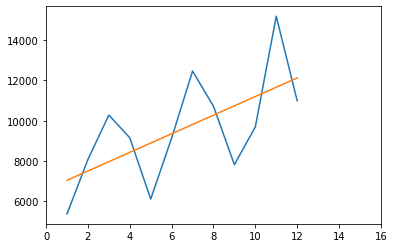

In [59]:
plt.plot(np.array(data.keys()), data.values[0])
plt.xlim([0, 16])
# m = slope, b=intercept
m, b = np.polyfit(np.array(data.keys()), data.values[0], 1)
plt.plot(np.array(data.keys()), m*np.array(data.keys())+b)

plt.show()

## 2. Predict future demand in month 13,14,15,16 without seasonality

### 1) Moving Average

In [103]:
# Add a Moving Average row 
df_T = data.T
df_T['MV'] = [0]*12

for i in range(4, 13):
    df_T['MV'][i] = (df_T['Sales'][i-1] + df_T['Sales'][i-2] + df_T['Sales'][i-3])/3
    
df_T['MV']

1         0
2         0
3         0
4      7915
5      9173
6      8518
7      8137
8      9239
9     10772
10    10334
11     9411
12    10898
Name: MV, dtype: int64

In [107]:
# Calculate 13, 14, 15, 16 month 
df_T['MV'][13]  = (df_T['MV'][10] + df_T['MV'][11] + df_T['MV'][12])/3
df_T['MV'][14]  = (df_T['MV'][11] + df_T['MV'][12] + m13)/3
df_T['MV'][15]  = (df_T['MV'][12] + m13 + m14)/3
df_T['MV'][16]  = (m13 + m14 + m15)/3

In [113]:
print(df_T['MV'][13],df_T['MV'][14],df_T['MV'][15],df_T['MV'][16])

10214.333333333334 10174.444444444445 10428.925925925927 10272.56790123457


### 2) Exponential Smoothing

In [117]:
a = 0.3

# Add a Moving Average row 
temp = data.T
temp['ES'] = [0]*12
temp['ES'][1] = temp['Sales'][1]

for i in range(2, 13):
    temp['ES'][i] = a * temp['Sales'][i-1] + (1-a) * temp['ES'][i-1]
    
temp

,Sales,ES
1,5384,5384
2,8081,5384
3,10282,6193
4,9156,7419
5,6118,7940
6,9139,7393
7,12460,7916
8,10717,9279
9,7825,9710
10,9693,9144


In [118]:
# Calculate 13, 14, 15, 16 month 
temp['ES'][13]  = a * temp['Sales'][12] + (1-a) * temp['ES'][12]
# temp['ES'][14]  = 
# temp['ES'][15]  = 
# temp['ES'][16]  = 
temp['ES'][13] 

11044.599999999999

## 3. Predict future demand in month 13,14,15,16 with seasonality

In [1]:
import math
def correlation_similarity(v1,v2):
    v1 = v1 - np.nanmean(v1)
    v2 = v2 - np.nanmean(v2)
    "compute similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if np.isnan(x) or np.isnan(y) or x == 0 or y ==0: continue
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxx == 0 and sumyy == 0:
        sumxx = sumyy = 1
    return sumxy/math.sqrt(sumxx*sumyy)

def sim_matrix(M, dimension='user'):
    N = M.shape[0] if dimension == 'user' else M.shape[1]
    print(N)
    sim = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i == j:
                sim[i,j] = 0 #Cancel out the effect of self-similarity in the sums later
                continue
            if dimension == 'user':
                v1, v2 = M[i,:], M[j,:]
            else:
                v1, v2 = M[:,i], M[:,j]
            sim[i][j] = correlation_similarity(v1,v2)
    print(sim.shape)
    return sim